In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e1963cdade1d27f4e160a8a36ba7b9dfd921412230ed23b4602acac73ef9fd53
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
spark = SparkSession.builder.appName('ml-diabetes').getOrCreate()
df = spark.read.csv('ML_hw_dataset.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: integer (nullable = true)



In [ ]:
df.show(10)

+---+-----------+--------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|        job| marital|        education|default|housing|loan| contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+-----------+--------+-----------------+-------+-------+----+--------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 44|blue-collar| married|         basic.4y|unknown|    yes|  no|cellular|  aug|        thu|     210|       1|  999|       0|nonexistent|         1.4|        93.444|        -36.1|    4.963|     5228.1|  0|
| 53| technician| married|          unknown|     no|     no|  no|cellular|  nov|        fri|     138|       1|  999|       0|nonexistent|        -0.1|          93.2|        -42

In [ ]:
df.groupby('y').count().show()

+---+-----+
|  y|count|
+---+-----+
|  1| 4640|
|  0|36548|
+---+-----+



In [ ]:
df.describe().show()

+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+-----------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|               age|    job| marital|education|default|housing| loan|  contact|month|day_of_week|         duration|          campaign|             pdays|           previous|poutcome|       emp_var_rate|    cons_price_idx|     cons_conf_idx|         euribor3m|      nr_employed|                  y|
+-------+------------------+-------+--------+---------+-------+-------+-----+---------+-----+-----------+-----------------+------------------+------------------+-------------------+--------+-------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|             41188|  41188|   41188|    41188|  41188|  41188|41188|    4

In [ ]:
df.columns

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed',
 'y']

# Fill Null values

In [ ]:
## See if we have missing values
from pyspark.sql.functions import when, count
df.select([count(when(df[c]==None, c)).alias(c) for c in df.columns]).show()

+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|age|job|marital|education|default|housing|loan|contact|month|day_of_week|duration|campaign|pdays|previous|poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+
|  0|  0|      0|        0|      0|      0|   0|      0|    0|          0|       0|       0|    0|       0|       0|           0|             0|            0|        0|          0|  0|
+---+---+-------+---------+-------+-------+----+-------+-----+-----------+--------+--------+-----+--------+--------+------------+--------------+-------------+---------+-----------+---+



#Correlation Matrix

<ipython-input-9-738b4ffef13b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Correlation_matrix = df.toPandas().corr()


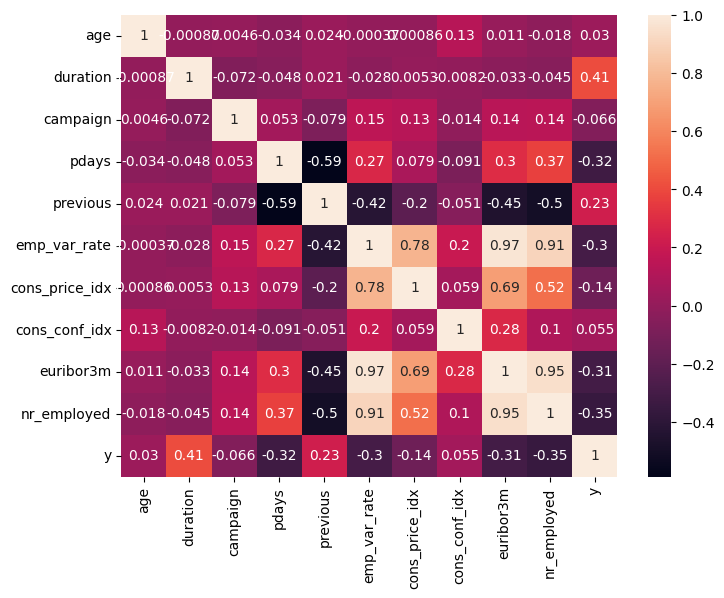

In [ ]:
Correlation_matrix = df.toPandas().corr() 
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(Correlation_matrix, annot=True)
plt.show()

# Indexing and One-Hot-Encoding

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.pandas import concat, Series

/usr/local/lib/python3.9/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [ ]:
df = StringIndexer(inputCol='job', outputCol='si_job').fit(df).transform(df)
df = StringIndexer(inputCol='marital', outputCol='si_marital').fit(df).transform(df)
df = StringIndexer(inputCol='education', outputCol='si_education').fit(df).transform(df)
df = StringIndexer(inputCol='default', outputCol='si_default').fit(df).transform(df)
df = StringIndexer(inputCol='housing', outputCol='si_housing').fit(df).transform(df)
df = StringIndexer(inputCol='loan', outputCol='si_loan').fit(df).transform(df)
df = StringIndexer(inputCol='contact', outputCol='si_contact').fit(df).transform(df)
df = StringIndexer(inputCol= 'poutcome', outputCol='si_poutcome').fit(df).transform(df)
df = StringIndexer(inputCol='month', outputCol='si_month').fit(df).transform(df)
df = StringIndexer(inputCol='day_of_week', outputCol='si_day').fit(df).transform(df)

#Select Features for Classification

In [ ]:
df.show()

+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------+----------+------------+----------+----------+-------+----------+-----------+--------+------+
|age|        job| marital|        education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp_var_rate|cons_price_idx|cons_conf_idx|euribor3m|nr_employed|  y|si_job|si_marital|si_education|si_default|si_housing|si_loan|si_contact|si_poutcome|si_month|si_day|
+---+-----------+--------+-----------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+------+----------+------------+----------+----------+-------+----------+-----------+--------+------+
| 44|blue-collar| married|         basic.4y|unknown|    yes|  no| cellular|  au

In [ ]:
assembler = VectorAssembler(inputCols = ['age', 'duration', 'campaign', 'pdays', 'previous',
                                         'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed',
                                         'si_job', 'si_marital', 'si_education', 'si_default', 'si_housing', 'si_loan',
                                         'si_contact', 'si_poutcome', 'si_month', 'si_day'],
                            outputCol = 'features')
output = assembler.transform(df)
final_data = output.select('features', 'y')

In [ ]:
final_data.show()

+--------------------+---+
|            features|  y|
+--------------------+---+
|[44.0,210.0,1.0,9...|  0|
|[53.0,138.0,1.0,9...|  0|
|[28.0,339.0,3.0,6...|  1|
|[39.0,185.0,2.0,9...|  0|
|[55.0,137.0,1.0,3...|  1|
|[30.0,68.0,8.0,99...|  0|
|(20,[0,1,2,3,5,6,...|  0|
|[39.0,191.0,1.0,9...|  0|
|[36.0,174.0,1.0,3...|  1|
|[27.0,191.0,2.0,9...|  0|
|[34.0,62.0,2.0,99...|  0|
|(20,[0,1,2,3,5,6,...|  0|
|[55.0,372.0,3.0,9...|  1|
|[33.0,75.0,5.0,99...|  0|
|[26.0,1021.0,1.0,...|  0|
|[52.0,117.0,2.0,9...|  0|
|[35.0,1034.0,2.0,...|  1|
|[27.0,540.0,1.0,9...|  1|
|[28.0,140.0,1.0,9...|  0|
|[26.0,104.0,4.0,9...|  0|
+--------------------+---+
only showing top 20 rows



In [ ]:
(trainingData, testData) = final_data.randomSplit([0.8, 0.2])

# Modeling

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import precision_score, recall_score
binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='y')

## Logestic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="y", featuresCol="features", maxIter=10)
model = lr.fit(trainingData)

predictions = model.transform(testData)
print('Logistic Regression Accuracy:', binary_evaluator.evaluate(predictions))
preds = predictions.toPandas()['prediction'].values
tar = predictions.toPandas()['y'].values
print('Logistic Regression Precision:', precision_score(tar, preds))
print('Logistic Regression Recall:', recall_score(tar, preds))

Logistic Regression Accuracy: 0.7012789470136336
Logistic Regression Precision: 0.6736474694589878
Logistic Regression Recall: 0.4279379157427938


## SVM

In [ ]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=20, regParam=0.1, labelCol="y", featuresCol="features")
model = lsvc.fit(trainingData)

predictions = model.transform(testData)
print('SVM Accuracy:', binary_evaluator.evaluate(predictions))
preds = predictions.toPandas()['prediction'].values
tar = predictions.toPandas()['y'].values
print('SVM Precision:', precision_score(tar, preds))
print('SVM Recall:', recall_score(tar, preds))


SVM Accuracy: 0.5901305700205359
SVM Precision: 0.5718849840255591
SVM Recall: 0.1984478935698448


## Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="y", featuresCol="features", maxDepth=5)
model = dt.fit(trainingData)

predictions = model.transform(testData)
print('DecisionTree Accuracy:', binary_evaluator.evaluate(predictions))
preds = predictions.toPandas()['prediction'].values
tar = predictions.toPandas()['y'].values
print('DecisionTree Precision:', precision_score(tar, preds))
print('DecisionTree Recall:', recall_score(tar, preds))

DecisionTree Accuracy: 0.7566220920574618
DecisionTree Precision: 0.6475195822454308
DecisionTree Recall: 0.549889135254989


## Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="y", featuresCol="features", maxDepth=5)
model = rf.fit(trainingData)

predictions = model.transform(testData)
print('RandomForest Accuracy:', binary_evaluator.evaluate(predictions))
preds = predictions.toPandas()['prediction'].values
tar = predictions.toPandas()['y'].values
print('RandomForest Precision:', precision_score(tar, preds))
print('RandomForest Recall:', recall_score(tar, preds))

RandomForest Accuracy: 0.6106847854087069
RandomForest Precision: 0.7536231884057971
RandomForest Recall: 0.23059866962305986
